In [1]:
# Import necessary libraries
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

from sklearn.model_selection import train_test_split

#NLP libraries
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from gensim.models import Doc2Vec
import gensim
from gensim.models.doc2vec import TaggedDocument

#Helper libraries
import multiprocessing
import numpy as np
import pandas as pd
import math
from bs4 import BeautifulSoup
import re
import os
import pandas as pd
import json


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path to the zip file
zip_path = '/content/drive/My Drive/data.zip'


# Function to read JSON files directly from zip
def load_json_files_from_zip(zip_path, json_folder):
    articles = []
    with zipfile.ZipFile(zip_path, 'r') as z:
        for file_info in z.infolist():
            if file_info.filename.startswith(json_folder) and file_info.filename.endswith('.json'):
                with z.open(file_info) as file:
                    articles.append(json.load(file))
    return articles



Mounted at /content/drive


In [3]:
# Adjust pandas display settings to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full content of each column
pd.set_option('display.width', None)  # Auto-detect width of the display

# Load articles from the 'jsons' folder inside the zip file
json_folder = 'data/jsons'
articles = load_json_files_from_zip(zip_path, json_folder)

# Convert to DataFrame
df = pd.DataFrame(articles)

# Display basic information about the dataset
print("Dataset Overview:")
print(df.info())
print("\nFirst 5 Articles:")
print(df.head())


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37554 entries, 0 to 37553
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   topic             37554 non-null  object
 1   source            37554 non-null  object
 2   bias              37554 non-null  int64 
 3   url               37554 non-null  object
 4   title             37554 non-null  object
 5   date              37554 non-null  object
 6   authors           37554 non-null  object
 7   content           37554 non-null  object
 8   content_original  37554 non-null  object
 9   source_url        37554 non-null  object
 10  bias_text         37554 non-null  object
 11  ID                37554 non-null  object
dtypes: int64(1), object(11)
memory usage: 3.4+ MB
None

First 5 Articles:
       topic            source  bias  \
0   politics          Politico     0   
1      china         Bloomberg     1   
2  terrorism  Washington Times    

In [4]:
# Get the minimum and maximum dates (as raw strings)
min_date_raw = df['date'].min()
max_date_raw = df['date'].max()
print("\nMinimum Date:", min_date_raw)
print("Maximum Date:", max_date_raw)


Minimum Date: 
Maximum Date: 9/6/17


In [5]:
#Cleaning up the dataset
# Check for rows with an empty or null date column
empty_date_rows = df[df['date'].isnull() | (df['date'] == '')]

# Count the number of rows with an empty or null date column
num_empty_date_rows = len(empty_date_rows)

print("\nNumber of Rows with an Empty or Null Date Column:", num_empty_date_rows)


Number of Rows with an Empty or Null Date Column: 4407


In [6]:
# Specify the columns to check for empty values
columns_to_check = ["topic", "bias", "source", "title", "date", "authors", "content", "content_original", "ID"]

# Find rows that have no value in any of the specified columns
rows_with_empty_values = df[df[columns_to_check].isnull().any(axis=1) | (df[columns_to_check] == '').any(axis=1)]

# Display the rows with empty values in the specified columns
print(len(rows_with_empty_values))

12372


In [36]:
# Find and delete rows that have no value in any of the specified columns
df_cleaned = df.dropna(subset=columns_to_check).replace('', pd.NA).dropna(subset=columns_to_check)
# Convert the 'date' column to datetime, handling errors
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'], errors='coerce')

# Drop rows where 'date' could not be parsed
df_cleaned = df_cleaned.dropna(subset=['date'])

# There is 1 article from 2007 and 2 articles from 2010. Remove articles from 2007 and 2010
df_cleaned = df_cleaned[~df_cleaned['date'].dt.year.isin([2007, 2010])]


# Display the shape of the cleaned DataFrame
print("Shape of the cleaned DataFrame:", df_cleaned.shape)

# Optional: Display the first few rows of the cleaned DataFrame
print(df_cleaned.head())

Shape of the cleaned DataFrame: (25143, 12)
       topic            source  bias  \
1      china         Bloomberg     1   
2  terrorism  Washington Times     2   
3   politics             Salon     0   
4   politics    CNN (Web News)     0   
5        nsa    CNN (Web News)     0   

                                                                                                                  url  \
1  https://www.bloomberg.com/news/articles/2018-07-11/trump-s-tariff-barrage-pushes-china-fight-to-point-of-no-return   
2                 http://www.washingtontimes.com/news/2014/sep/16/top-general-foley-rescue-highest-risk-mission-ever/   
3   http://www.salon.com/2014/11/12/americas_post_midterm_inferno_tea_party_garbage_media_nonsense_and_economic_hell/   
4                                                   http://www.cnn.com/2014/01/08/politics/christie-bridge/index.html   
5                                      http://www.cnn.com/2014/01/24/world/europe/russia-snowden/index.html?hp

In [37]:
#Additional EDA and Data Clearning Begins Here
df_cleaned['content'][1]

'LISTEN TO ARTICLE 5:37 SHARE THIS ARTICLE Share Tweet Post Email\nU.S. President Donald Trump is pushing his trade conflict with China toward a point where neither side can back down .\nBy Aug. 30 , as the U.S. nears mid-term elections vital for Trump ’ s legislative agenda , the White House will be ready to impose 10 percent tariffs on $ 200 billion of Chinese-made products , ranging from clothing to television parts to refrigerators . The levies announced Tuesday -- together with some $ 50 billion already in the works -- stand to raise import prices on almost half of everything the U.S. buys from the Asian nation .\nChina has seven weeks to make a deal or dig in and try to outlast the U.S. leader . President Xi Jinping , facing his own political pressures to look tough , has vowed to respond blow-for-blow . He ’ s already imposed retaliatory duties targeting Trump ’ s base including Iowa soybeans and Kentucky bourbon .\nYet matching the latest U.S. barrage would force China to eithe

In [38]:
#Remove stop words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#Download the 'stopwords' resource
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(content):
    for word in stop_words:
        content = content.replace(' '+word+' ',' ')
    return content

#Special Character Removals
def clean(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text)
    text = text.replace('„','')
    text = text.replace('“','')
    text = text.replace('"','')
    text = text.replace('\'','')
    text = text.replace('-','')
    text = text.lower()
    return text


df_cleaned['content_original'] = df_cleaned['content_original'].apply(clean)
df_cleaned['content_original'] = df_cleaned['content_original'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
#Lemmatization, Reduce words to their base or root form
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

df_cleaned['content_original'] = df_cleaned['content_original'].apply(lemmatize_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [40]:
#Handling abbreviations
def expand_contractions(text):
    contractions = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'll": "I will",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mightn't": "might not",
    "mustn't": "must not",
    "needn't": "need not",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "shan't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "shouldn't": "should not",
    "that'd": "that would",
    "that's": "that is",
    "there'd": "there would",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where'd": "where did",
    "where's": "where is",
    "who'd": "who would",
    "who'll": "who will",
    "who're": "who are",
    "who's": "who is",
    "who've": "who have",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have"

    }
    for contraction, expansion in contractions.items():
        text = re.sub(contraction, expansion, text)
    return text

df_cleaned['content_original'] = df_cleaned['content_original'].apply(expand_contractions)

In [ ]:
# #Named entity recognition using SPACY, Identify and standardize names of people, organizations, and locations.
# import spacy

# nlp = spacy.load("en_core_web_sm")

# def standardize_entities(text):
#     doc = nlp(text)
#     for ent in doc.ents:
#         text = text.replace(ent.text, f"{ent.label_}_{ent.text}")
#     return text

# df['content_original'] = df['content_original'].apply(standardize_entities)

In [41]:
#Apply the cleanings to the news article title as well
df_cleaned['title'] = df_cleaned['title'].apply(clean)
df_cleaned['title'] = df_cleaned['title'].apply(remove_stopwords)
df_cleaned['title'] = df_cleaned['title'].apply(lemmatize_text)
df_cleaned['title'] = df_cleaned['title'].apply(expand_contractions)

<ipython-input-38-e3a6feb374b5>:16: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text
<ipython-input-38-e3a6feb374b5>:16: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text


In [42]:
def remove_share_button_info(text):
    pattern = r'\b(listen article \d+:\d+ share article share tweet post email)\b'
    return re.sub(pattern, '', text, flags=re.IGNORECASE).strip()

df_cleaned['content_original'] = df_cleaned['content_original'].apply(remove_share_button_info)

In [43]:
df_cleaned['content_original'][1]

'u.s. president donald trump pushing trade conflict china toward point neither side back down. by aug. 30, u.s. nears midterm election vital trump’s legislative agenda, white house ready impose 10 percent tariff $200 billion chinesemade products, ranging clothing television part refrigerators. levy announced tuesday together $50 billion already work stand raise import price almost half everything u.s. buy asian nation. china seven week make deal dig try outlast u.s. leader. president xi jinping, facing political pressure look tough, vowed respond blowforblow. he’s already imposed retaliatory duty targeting trump’s base including iowa soybean kentucky bourbon. yet matching latest u.s. barrage would force china either levy much higher tariff take disruptive step like canceling purchase orders, encouraging consumer boycott putting regulatory hurdles. risk provoking trump follow threat tax virtually chinese products, could unleash nationalist sentiment side fuel deeper struggle geopolitica

In [24]:
df_cleaned['title'].head(5)

1                               trump’s tariff barrage push china fight point return
2                        top general: failed foley rescue ‘highestrisk mission’ ever
3    america’s postmidterm inferno: tea party garbage, medium nonsense economic hell
4                          email among christie appointee suggest political vendetta
5                               edward snowden wont pressured end asylum, russia say
Name: title, dtype: object

In [ ]:
# End of Adding ON addtional Data Cleanings to the EDA Step


Political Bias Distribution:
bias_text
left      10275
right      9047
center     5821
Name: count, dtype: int64


<ipython-input-44-2155182a9f67>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='bias_text', data=df_cleaned, palette='coolwarm')


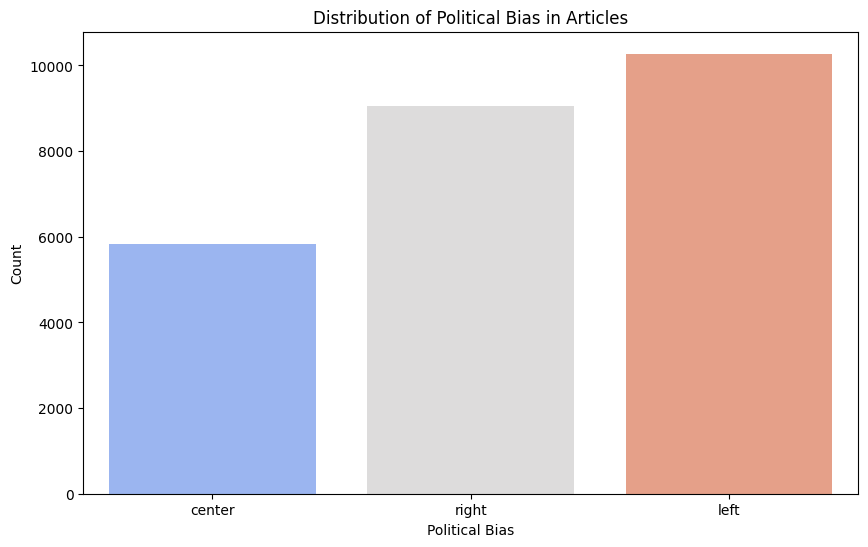


Top 10 Topics Distribution:
topic
elections                     4260
politics                      1867
white_house                   1167
immigration                   1098
healthcare                    1016
media_bias                     715
gun_control_and_gun_rights     629
middle_east                    627
coronavirus                    616
supreme_court                  510
Name: count, dtype: int64


<ipython-input-44-2155182a9f67>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='topic', data=df[df['topic'].isin(topic_counts.index)], palette='viridis', order=topic_counts.index)


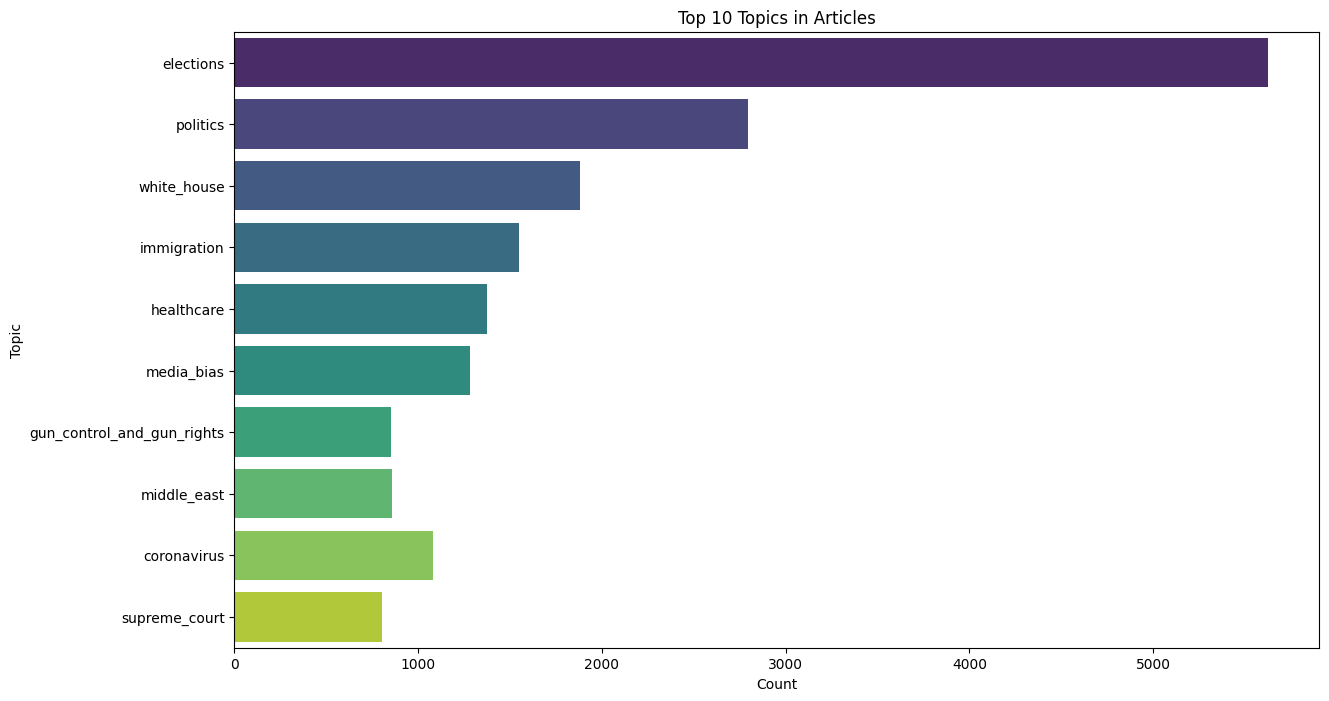


Sample Article Content:
This happens for different reasons, but a key element is the vicious cycle between holding strong attitudes on an issue and something called “selective perception.” Essentially, the stronger your views are on an issue like Trump’s impeachment, the more likely you are to attend more carefully to information that supports your views and to ignore or disregard information that contradicts them. Consuming more belief-consistent information will, in turn, increase your original support or disapproval for impeachment, which just fortifies your attitudes. So, no, not much change will be seen in the minds of the 33 percent.

Except, maybe. One of the more interesting findings from research on attitude change is that our more important, self-defining attitudes do not seem to change incrementally, a little at a time, but they can change dramatically, from one extreme to another. Typically, when others try to change our views on important issues that we hold firmly, their

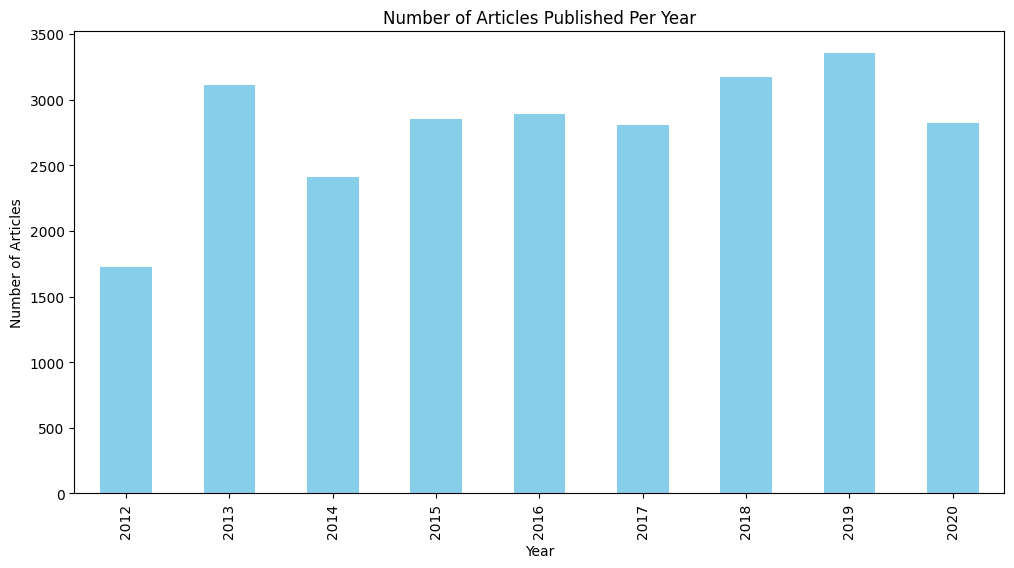

In [44]:

# Summarize the distribution of political bias
bias_counts = df_cleaned['bias_text'].value_counts()
print("\nPolitical Bias Distribution:")
print(bias_counts)

# Plot the distribution of political bias
plt.figure(figsize=(10, 6))
sns.countplot(x='bias_text', data=df_cleaned, palette='coolwarm')
plt.title('Distribution of Political Bias in Articles')
plt.xlabel('Political Bias')
plt.ylabel('Count')
plt.show()

# Summarize the distribution of topics
topic_counts = df_cleaned['topic'].value_counts().head(10)
print("\nTop 10 Topics Distribution:")
print(topic_counts)

# Plot the distribution of top 10 topics
plt.figure(figsize=(14, 8))
sns.countplot(y='topic', data=df[df['topic'].isin(topic_counts.index)], palette='viridis', order=topic_counts.index)
plt.title('Top 10 Topics in Articles')
plt.xlabel('Count')
plt.ylabel('Topic')
plt.show()

# Display a sample article content
print("\nSample Article Content:")
print(df['content_original'].iloc[0])

# Check the distribution of articles over time
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'])
articles_per_year = df_cleaned['date'].dt.year.value_counts().sort_index()
print("\nArticles Per Year:")
print(articles_per_year)

# Plot the distribution of articles over time
plt.figure(figsize=(12, 6))
articles_per_year.plot(kind='bar', color='skyblue')
plt.title('Number of Articles Published Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.show()

In [45]:
df_cleaned.columns

Index(['topic', 'source', 'bias', 'url', 'title', 'date', 'authors', 'content', 'content_original',
       'source_url', 'bias_text', 'ID'],
      dtype='object')

In [46]:
#shrink down the df_cleaned dataset size by excluding irrelevant columns
df_cleaned = df_cleaned[['title','date','content_original','bias','bias_text','source']]

In [47]:
df_cleaned.head(1)

title       date  \
1  trump’s tariff barrage push china fight point return 2018-07-11   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [32]:
# Convert 'date' column back to string type if needed
df_cleaned['date'] = df_cleaned['date'].astype(str)

# filtering 2016's news articles only
df_cleaned = df_cleaned[df_cleaned['date'].str.startswith('2016')]


Articles Per Year:
date
2012    1723
2013    3111
2014    2411
2015    2850
2016    2893
2017    2804
2018    3173
2019    3352
2020    2826
Name: count, dtype: int64


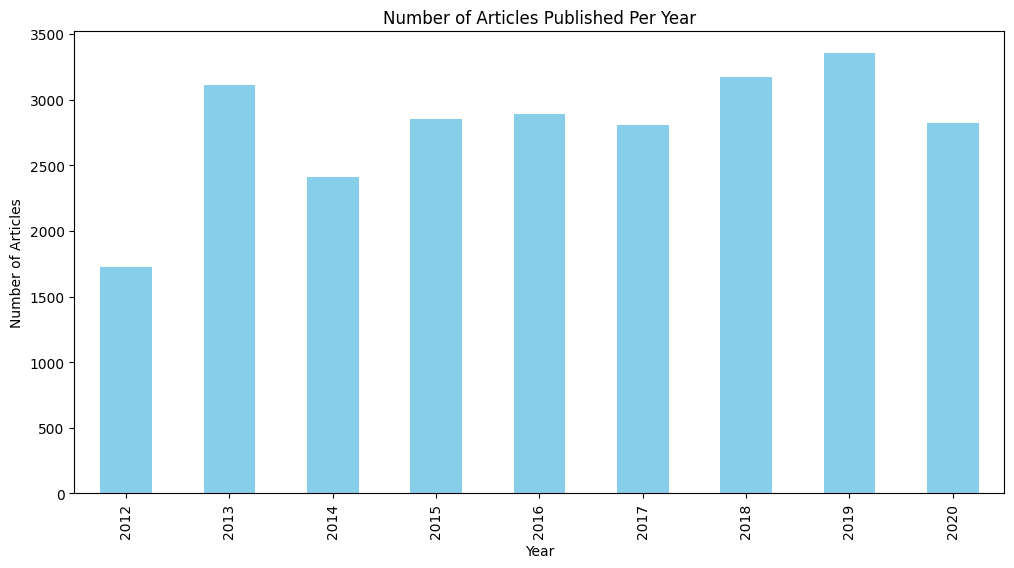

In [48]:
# Check the distribution of articles over time
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'])
articles_per_year = df_cleaned['date'].dt.year.value_counts().sort_index()
print("\nArticles Per Year:")
print(articles_per_year)

# Plot the distribution of articles over time
plt.figure(figsize=(12, 6))
articles_per_year.plot(kind='bar', color='skyblue')
plt.title('Number of Articles Published Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.show()

In [34]:
#dataset with 2016 published articles only
df_cleaned.to_csv('/content/drive/My Drive/Datasci_266_Final_Project/2016_data(Revised).csv', index=False)

In [49]:
#full dataset
df_cleaned.to_csv('/content/drive/My Drive/Datasci_266_Final_Project/full_dataset(Revised).csv', index=False)

In [50]:
# Split the data into training and test sets
train_df, test_df = train_test_split(df_cleaned, test_size=0.2, random_state=42)

# Display the size of the training and test sets
print("\nSize of training set:", train_df.shape)
print("Size of test set:", test_df.shape)

# Save the splits to CSV files for later use
train_df.to_csv('/content/drive/My Drive/Datasci_266_Final_Project/full_train_data(Revised).csv', index=False)
test_df.to_csv('/content/drive/My Drive/Datasci_266_Final_Project/full_test_data(Revised).csv', index=False)


Size of training set: (20114, 6)
Size of test set: (5029, 6)
